## How to train your model

In [1]:
from fastai.basics import *
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math
import matplotlib as mpl
import torch
import matplotlib.pyplot as plt
from torch import tensor

import time

def timeit(func):
    def wrapper(*args, **kwargs):
        now = time.time()
        retval = func(*args, **kwargs)
        print('{} took {:.5f}s'.format(func.__name__, time.time() - now))
        return retval
    return wrapper


# if not exist, download mnist dataset
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

In [2]:
def get_data():
    path = "/work2/05515/bflynn/frontera/data/mnist.pkl.gz"
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))

In [3]:
def normalize(x, m, s): return (x-m)/s

In [4]:
x_train,y_train,x_valid,y_valid = get_data()

In [5]:
x_train.shape

torch.Size([50000, 784])

In [6]:
y_train.shape

torch.Size([50000])

In [7]:
x_valid.shape

torch.Size([10000, 784])

In [8]:
y_valid.shape

torch.Size([10000])

In [9]:
train_mean,train_std = x_train.mean(),x_train.std()
train_mean,train_std

(tensor(0.1304), tensor(0.3073))

In [10]:
x_train = normalize(x_train, train_mean, train_std)
# NB: Use training, not validation mean for validation set
# Why? If you normalize the two datasets with differently, they'll be on 
# totally different scales from one another - won't be able to tell 
# the differences between images in both sets 
x_valid = normalize(x_valid, train_mean, train_std)

In [11]:
mpl.rcParams['image.cmap'] = 'gray'

In [12]:
img = x_train[0]

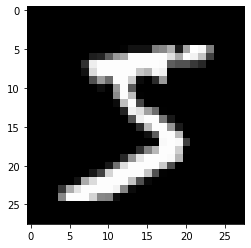

In [13]:
plt.imshow(img.view((28,28)));

# Why the hell do inits matter?

And why you need a good one

In [14]:
x = torch.randn(512)
a = torch.randn(512,512)

In [15]:
for i in range(100): x = a @ x

In [16]:
x.mean(), x.std()

(tensor(nan), tensor(nan))

### What the heck happened? Activation explosion!
Let's ask the loop to break when our activations explode

In [17]:
x = torch.randn(512)
a = torch.randn(512,512)

In [18]:
for i in range(100):
    x = a @ x
    if x.std() != x.std(): break

In [19]:
i

28

It only takes 28 iterations until our activations explode!

What about if we initialize our activations with a scale that is really low?

In [20]:
x = torch.randn(512)
a = torch.randn(512,512)*0.01

In [21]:
for i in range(100): x = a @ x

In [22]:
x.mean(), x.std()

(tensor(0.), tensor(0.))

So now every activation has vanished, to zero. **This is the reason why we couldn't train deep neural networks for so long - initializing them is challenging and you need to pick the right initialization or your activations get too big to handle (nan) or vanish entirely!**

Some strategies to properly initialize - 

- use stdev that will make sure x and ax have the *same* scale
- orthogonal matrix initializes weight, so x and ax would have same sum of squares by preserving the L2 norm
- spectral normalization on matrix A (spectral norm is least possible number M such that ```torch.norm(A@x) <= M*torch.norm(x)``` so dividing A by this M insures you don't overflow. You can still vanish with this)

# Xavier initialization

TLDR: scale equal to ```1/math.sqrt(n_in)```, where ```n_in``` is the **number of inputs of our matrix**.

In [23]:
import math

x = torch.randn(512)
a = torch.randn(512,512)/math.sqrt(512)

In [24]:
for i in range(100): x = a @ x

In [25]:
x.mean(), x.std()

(tensor(-0.1363), tensor(7.0877))

# Kaiming initialization

PyTorch kaiming init for reference ( just an example )

In [26]:
nh = 32 # number of hidden layers just an example
l1 = nn.Conv2d(1, nh, 5)

In [27]:
nn.init.kaiming_normal_(l1.weight, a=1.);

# All you need is a good init - paper

In [28]:
# layering matrix multiplication, relu, fully connect it forward and then backward to pass back the gradients

In [29]:
# Model Data (vars initialized above)

In [30]:
n, m = x_train.shape
c = y_train.max()+1
nh = 50

In [31]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [32]:
model = Model(m, nh, 10)

In [33]:
pred = model(x_train)

In [34]:
# Need a loss function, without it we can't train

# Cross Entropy Loss

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$ 

In practice, we will need the log of the softmax when we calculate the loss.

In [35]:
# in code form: 

def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [36]:
sm_pred = log_softmax(pred)

In [37]:
# when you multiply by zero in a one hot encoded vector, doing nothing and also slow
# faster way - what is the location of what you care about? which is one
# Use the index of our actual! (the one in a one hot encoded matrix or vector)

In [38]:
y_train[:3]

tensor([5, 0, 4])

In [39]:
sm_pred.shape # sm = softmax predictions
# 50,000 for all images in training set, 10 for number of pred categories

torch.Size([50000, 10])

In [40]:
sm_pred[0][5]

tensor(-1.9466, grad_fn=<SelectBackward>)

In [41]:
sm_pred[[0,1,2], [5,0,4]] 
# works because pytorch does numpy advanced indexing!
# integer array indexing

# can pass a list for each dimension(2 dims, 2 lists)
# first is the row indexes you want
# second is the column indexes you want

# returns 0,5 - 1,0 - 2,4
# check that above and below 0,5 are the same

tensor([-1.9466, -2.2533, -2.4473], grad_fn=<IndexBackward>)

In [42]:
y_train.shape[0]

50000

In [43]:
# negative log likelihood function
def nll(input, target): return -input[range(target.shape[0]), target].mean()

# all row indexes, and targets is columns we want
# include "-" before input - because negative log likelihood
# then, take the mean

In [44]:
# loss is the negative log likelihood of softmax predictions, compared 
# to actual training (y_training)

loss = nll(sm_pred, y_train)

In [45]:
loss

tensor(2.3448, grad_fn=<NegBackward>)

Note that the formula 

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$ 

gives a simplification when we compute the log softmax, which was previously defined as `(x.exp()/(x.exp().sum(-1,keepdim=True))).log()`

In [46]:
def log_softmax(x): return x - x.exp().sum(-1, keepdim=True).log()

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In [47]:
# when you go x.exp() - can get very big numbers
# huge numbers in floating numbers on a computer, wildly inprecise
# computer could thing two huge numbers 1000 apart are exactly the same

In [48]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:, None]).exp().sum(-1).log()

### In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`.

____

# Basic Training

Basically the training loop repeats over the following steps:
- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

In [49]:
loss_func = F.cross_entropy

In [50]:
def accuracy(out, yb): return (torch.argmax(out, dim=1) == yb).float().mean()
# grab argmax, which number in softmax is highest, index of that is our prediction
# (index would be what category was predicted in the one hot encoded matrix)
# check whether that's equal to the actual
# take the mean, convert it to a float first (can't take mean of int in pytorch)

In [51]:
bs = 64
xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape

(tensor([ 0.1760, -0.3334,  0.6334, -0.0093, -0.2983,  0.5190, -0.2911,  0.5797,
         -0.0902,  0.1106], grad_fn=<SelectBackward>),
 torch.Size([64, 10]))

In [52]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.3418, grad_fn=<NllLossBackward>)

In [53]:
accuracy(preds, yb) 
# haven't trained our model yet, so the accuracy based on the 
# randomly initialized parameters is 10 ish percent

tensor(0.0312)

In [54]:
lr = 0.5 # learning rate
epochs = 1 # how many epochs to train for

## Training loop

- calculate predictions
- calculate your loss
- do backward pass
- **subtract learning rate times gradients**
- and then **zero the gradients**

In [55]:
for epoch in range(epochs):
    for i in range((n-1)//bs+1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i : end_i]
        yb = y_train[start_i : end_i]
        loss = loss_func(model(xb), yb)
        
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad*lr
                    l.bias -= l.bias.grad*lr
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_()

In [56]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2007, grad_fn=<NllLossBackward>), tensor(0.9375))

# Using parameters and optim

In [57]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)

            loss.backward()
            ## with torch.no_grad() refactoring, replace with
            # model.parameters
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [58]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2007, grad_fn=<NllLossBackward>), tensor(0.9375))

Behind the scenes, PyTorch overrides the `__setattr__` function in `nn.Module` so that the submodules you define are properly registered as parameters of the model.

In [59]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        # every time set an attribute, update a list of _modules wiht list of all modules I have
    def __setattr__(self,k,v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k,v)
        
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [60]:
mdl = DummyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [61]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__() ## it has to set up dummy modules _modules dictionary
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))

In [62]:
model = Model(m, nh, 10)

In [63]:
for name, l in model.named_children(): print(f"{name}:{l}")

l1:Linear(in_features=784, out_features=50, bias=True)
l2:Linear(in_features=50, out_features=10, bias=True)


In [64]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

# Registering modules

In [65]:
layers = [nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10)]

In [66]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__() # needed to set up module dictionary
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [67]:
model = Model(layers)

In [68]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

## nn.ModuleList

In [69]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [70]:
model = SequentialModel(layers)

In [71]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [72]:
nn.Sequential??

# Optim

**Further refactoring**

Let's replace our previous manually coded optimization step:

```python
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```

and instead use just:

```python
opt.step()
opt.zero_grad()
```

In [73]:
class Optimizer():
    def __init__(self, params, lr=0.5): 
        self.params,self.lr=list(params),lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr
                
    # select only parameters that you want to optimize, and zero 
    # their gradients

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [74]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [75]:
opt = Optimizer(model.parameters())

In [76]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [77]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.8076, grad_fn=<NllLossBackward>), tensor(0.8125))

In [78]:
from torch import optim

In [79]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [80]:
model,opt = get_model()
loss_func(model(xb), yb)

tensor(2.3353, grad_fn=<NllLossBackward>)

In [81]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [82]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.9692, grad_fn=<NllLossBackward>), tensor(0.7500))

In [83]:
assert acc>0.7

# When you're developing ...

Don't set a random seed - if there's variation going on in the model at different times, we want to see it. 

#### Don't want it to be shielded by setting one random seed that works well

Though reproducibility is key, great for doing science, not how you should develop your models at the beginning. Developing your models, you want intuitive sense of:
- is it stable?
- how much variation do you expect?

If you have a test where it fails every 100 times, you want to know that! 

Can help with verifying stability and working to improve stability

# Dataset and DataLoader

It's clunky to iterate through minibatches of x and y values separately:

```python
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
```

Instead, let's do these two steps together, by introducing a `Dataset` class:

```python
    xb,yb = train_ds[i*bs : i*bs+bs]
```

In [84]:
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x) # len of something - length of dataset now stored
    def __getitem__(self, i): return self.x[i],self.y[i] # return tuple of x[i] and y[i]

In [85]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [86]:
xb,yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb

(tensor([[-0.4244, -0.4244, -0.4244,  ..., -0.4244, -0.4244, -0.4244],
         [-0.4244, -0.4244, -0.4244,  ..., -0.4244, -0.4244, -0.4244],
         [-0.4244, -0.4244, -0.4244,  ..., -0.4244, -0.4244, -0.4244],
         [-0.4244, -0.4244, -0.4244,  ..., -0.4244, -0.4244, -0.4244],
         [-0.4244, -0.4244, -0.4244,  ..., -0.4244, -0.4244, -0.4244]]),
 tensor([5, 0, 4, 1, 9]))

In [87]:
model,opt = get_model()

In [88]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb,yb = train_ds[i*bs : i*bs+bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [89]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
acc

tensor(0.8750)

In [90]:
class DataLoader():
    def __init__(self,ds, bs): self.ds, self.bs = ds,bs
    # class that takes dataset and batch size, stores them away
    # loop through range from 0 to size of datase
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): # up to 500000
            yield self.ds[i:i+self.bs] # end at 1 + self. batch size
            
    # yield - co-routine 
    # have a function that doesn't return one thing once, 
    # return lots of things lots of times - each time you call next, return the next thing that is yielded

In [91]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [92]:
xb, yb = next(iter(valid_dl))
assert xb.shape == (bs, 28*28)
assert yb.shape == (bs, )

tensor(3)

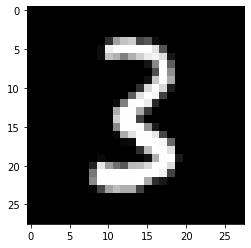

In [93]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [94]:
model,opt = get_model()

In [95]:
def fit():
    for epoch in range(epochs): # go through each epoch
        for xb, yb in train_dl: # go through each batch, grabbing independent and dependent variables
            pred = model(xb) # calculate the predictions
            loss = loss_func(pred, yb) # calculate the losses
            loss.backward() # calculate the gradients
            opt.step() # update with the learning rate
            opt.zero_grad() # reset the gradients

In [96]:
fit()

Want code to be this good as a researcher, because it gives you the freedom to try new cool stuff without bugs that you didn't know about, without interpretability by your domain expert colleagues, and so on.

In [97]:
loss, acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc > 0.7
loss, acc

(tensor(0.2686, grad_fn=<NllLossBackward>), tensor(0.9531))

### This is still problematic because it's going through the training set in the same order every time

We want the randomness of order for better generalizability

In [98]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n,self.bs,self.shuffle = len(ds),bs,shuffle
        
    def __iter__(self): # grab random permutation if not already shuffled
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [99]:
small_ds = Dataset(*train_ds[:10])

In [100]:
s = Sampler(small_ds, 3, False)

In [101]:
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [102]:
s = Sampler(small_ds, 3, True)

In [103]:
[o for o in s]

[tensor([4, 2, 7]), tensor([5, 6, 1]), tensor([0, 9, 3]), tensor([8])]

In [104]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)
# could change this if you want to add padding, etc
class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds,self.sampler,self.collate_fn = ds,sampler,collate_fn
    # pass dataloader sampler, looping through with yield avoids memory issues
    # grab indexes and ds at index, gives list of tensors, collate them into a single pair of tensors
    # collate grabs x and y and glues them together on a new axis
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [105]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [106]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

tensor(3)

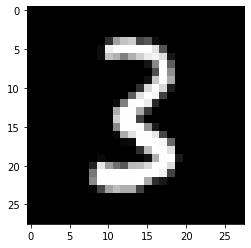

In [107]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(2)

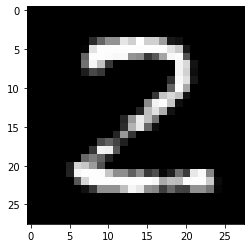

In [108]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(5)

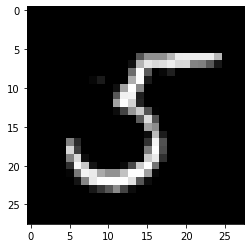

In [109]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [110]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.2532, grad_fn=<NllLossBackward>), tensor(0.9375))

In [111]:
# pytorch's dataloader

In [112]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [113]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [114]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2060, grad_fn=<NllLossBackward>), tensor(0.9688))

Note that PyTorch's `DataLoader`, if you pass `num_workers`, will use multiple threads to call your `Dataset`.

# Valid

You **always** should also have a [validation set](http://www.fast.ai/2017/11/13/validation-sets/), in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [115]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Handle batchnorm / dropout
        model.train()
#         print(model.training)
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
#         print(model.training)
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                pred = model(xb)
                # no backwards - not calculating gradients for the 
                # validation set
                tot_loss += loss_func(pred, yb) # keep track of loss
                tot_acc  += accuracy (pred,yb) # keep track of acc
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

*Question*: Are these validation results correct if batch size varies?

#### You need to actually weight according to the size of the minibatch
if you get the accuracy and loss for minibatch of 1 vs minibatch of 10001, can't really compare the two

However, this is how almost every library does it

Does NOT work correctly when you batch size varies

#### Question - why do you have to zero out your gradients in pytorch?

If we didn't zero out, when we go loss.backwards will add the new gradients to the existing gradients

We often have lots of sources of gradients, lots of modules all connected together

When we call backward we wouldn't want backward to zero the gradients

We need the grad.zero after calling backward

In [116]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [117]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()
loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.2141) tensor(0.9415)
1 tensor(0.1781) tensor(0.9507)
2 tensor(0.1783) tensor(0.9537)
3 tensor(0.5228) tensor(0.8956)
4 tensor(0.1647) tensor(0.9539)


In [118]:
assert acc>0.9

# Callbacks 

Callbacks let you fully customize every one of the steps
- Model
- Loss
- Gradients
- Step

In [119]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,64
c = y_train.max().item()+1
loss_func = F.cross_entropy

Factor out the connected pieces of info out of the fit() argument list

`fit(epochs, model, loss_func, opt, train_dl, valid_dl)`

Let's replace it with something that looks like this:

`fit(1, learn)`

This will allow us to tweak what's happening inside the training loop in other places of the code because the `Learner` object will be mutable, so changing any of its attribute elsewhere will be seen in our training loop.

In [120]:
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl,self.valid_dl,self.c = train_dl,valid_dl,c
        
    @property
    def train_ds(self): return self.train_dl.dataset
        
    @property
    def valid_ds(self): return self.valid_dl.dataset

In [121]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [122]:
def get_model(data, lr=0.5, nh=50):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,data.c))
    return model, optim.SGD(model.parameters(), lr=lr)

class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model,self.opt,self.loss_func,self.data = model,opt,loss_func,data

In [123]:
learn = Learner(*get_model(data), loss_func, data)

In [124]:
# Learner has no logic at all - just a storage device for model, optimizer, loss function and training data

In [125]:
# exact same thing, except now we access our tools we need from 
# learn where we stored all our stuff in previously

def fit(epochs, learn):
    for epoch in range(epochs):
        learn.model.train()
        for xb,yb in learn.data.train_dl:
            loss = learn.loss_func(learn.model(xb), yb)
            loss.backward()
            learn.opt.step()
            learn.opt.zero_grad()

        learn.model.eval()
        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in learn.data.valid_dl:
                pred = learn.model(xb)
                tot_loss += learn.loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(learn.data.valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [126]:
loss,acc = fit(1, learn)

0 tensor(0.3427) tensor(0.8992)


In [127]:
def one_batch(xb, yb, cb):
    if not cb.begin_batch(xb,yb): return
    loss = cb.learn.loss_func(cb.learn.model(xb), yb)
    if not cb.after_loss(loss): return
    loss.backward()
    if cb.after_backward(): cb.learn.opt.step()
    if cb.after_step(): cb.learn.opt.zero_grad()

def all_batches(dl, cb):
    for xb,yb in dl:
        one_batch(xb, yb, cb)
        if cb.do_stop(): return

def fit(epochs, learn, cb):
    if not cb.begin_fit(learn): return
    for epoch in range(epochs):
        if not cb.begin_epoch(epoch): continue
        all_batches(learn.data.train_dl, cb)
        
        if cb.begin_validate():
            with torch.no_grad(): all_batches(learn.data.valid_dl, cb)
        if cb.do_stop() or not cb.after_epoch(): break
    cb.after_fit()

In [128]:
class Callback():
    def begin_fit(self, learn):
        self.learn = learn
        return True
    def after_fit(self): return True
    def begin_epoch(self, epoch):
        self.epoch=epoch
        return True
    def begin_validate(self): return True
    def after_epoch(self): return True
    def begin_batch(self, xb, yb):
        self.xb,self.yb = xb,yb
        return True
    def after_loss(self, loss):
        self.loss = loss
        return True
    def after_backward(self): return True
    def after_step(self): return True

In [129]:
class CallbackHandler():
    def __init__(self,cbs=None):
        self.cbs = cbs if cbs else []

    def begin_fit(self, learn):
        self.learn,self.in_train = learn,True
        learn.stop = False
        res = True
        for cb in self.cbs: res = res and cb.begin_fit(learn)
        return res

    def after_fit(self):
        res = not self.in_train
        for cb in self.cbs: res = res and cb.after_fit()
        return res
    
    def begin_epoch(self, epoch):
        self.learn.model.train()
        self.in_train=True
        res = True
        for cb in self.cbs: res = res and cb.begin_epoch(epoch)
        return res

    def begin_validate(self):
        self.learn.model.eval()
        self.in_train=False
        res = True
        for cb in self.cbs: res = res and cb.begin_validate()
        return res

    def after_epoch(self):
        res = True
        for cb in self.cbs: res = res and cb.after_epoch()
        return res
    
    def begin_batch(self, xb, yb):
        res = True
        for cb in self.cbs: res = res and cb.begin_batch(xb, yb)
        return res

    def after_loss(self, loss):
        res = self.in_train
        for cb in self.cbs: res = res and cb.after_loss(loss)
        return res

    def after_backward(self):
        res = True
        for cb in self.cbs: res = res and cb.after_backward()
        return res

    def after_step(self):
        res = True
        for cb in self.cbs: res = res and cb.after_step()
        return res
    
    def do_stop(self):
        try:     return self.learn.stop
        finally: self.learn.stop = False

In [130]:
class TestCallback(Callback):
    def begin_fit(self,learn):
        super().begin_fit(learn)
        self.n_iters = 0
        return True
        
    def after_step(self):
        self.n_iters += 1
        print(self.n_iters)
        if self.n_iters>=10: self.learn.stop = True
        return True

In [131]:
fit(1, learn, cb = CallbackHandler([TestCallback()])) # batches

1
2
3
4
5
6
7
8
9
10


In [132]:
#export
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, yb):
        self.xb,self.yb = xb,yb
        if self('begin_batch'): return
        self.pred = self.model(self.xb)
        if self('after_pred'): return
        self.loss = self.loss_func(self.pred, self.yb)
        if self('after_loss') or not self.in_train: return
        self.loss.backward()
        if self('after_backward'): return
        self.opt.step()
        if self('after_step'): return
        self.opt.zero_grad()

    def all_batches(self, dl):
        self.iters = len(dl)
        for xb,yb in dl:
            if self.stop: break
            self.one_batch(xb, yb)
            self('after_batch')
        self.stop=False

    def fit(self, epochs, learn):
        self.epochs,self.learn = epochs,learn

        try:
            for cb in self.cbs: cb.set_runner(self)
            if self('begin_fit'): return
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                if self('after_epoch'): break
            
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        for cb in sorted(self.cbs, key=lambda x: x._order):
            f = getattr(cb, cb_name, None)
            if f and f(): return True
        return False

## Annealing

We define two new callbacks: the Recorder to save track of the loss and our scheduled learning rate, and a ParamScheduler that can schedule any hyperparameter as long as it's registered in the state_dict of the optimizer. 

Hyperparameter scheduling - learning rate

You can and should schedule everything - dropout amount, weight decay, learning rate, momentum, everything

Different phases in the loss landscapes of neural nets - look very different at the start, middle, and end 

Very unlikely that you want the same things for all parts of training so being able to schedule things is a good idea

In [133]:
#export
class Recorder(Callback): # at the start of fitting, sets losses and lrs to empty
    def begin_fit(self): self.lrs,self.losses = [],[]

        # when training append the current lr and loss
    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr']) # this is the final layer group learning rate
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func

    def set_param(self):
        for pg in self.opt.param_groups: # layer groups = param groups; pytorch optimizer contains param_groups, loop through
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
    
    # this says everytime we start a batch, run our scheduler
    def begin_batch(self): 
        if self.in_train: self.set_param()

In [134]:
def sched_lin(start, end):
    def _inner(start, end, pos): return start + pos * (end-start)
    return partial(_inner, start, end)
# the function takes a start end and position of learning rate, returns a learning rate

In [135]:
# refactor this with a decorator

def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos * (end-start)

A decorator is a function that returns a function
Takes the written function, passes it into the function called with the '@' sign, and replaces the definition of the function with whatever is returned

In [136]:
f = sched_lin(1,2)
f(0.3)

1.3

In [137]:
# Other scheduler functions
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

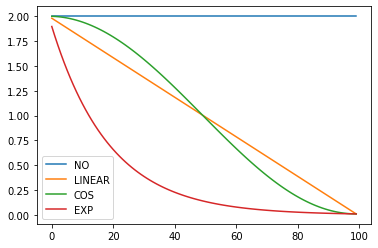

In [138]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In [139]:
# combine different schedulers (might want a warm up and cool down type scheduler)
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        if idx == 2: idx = 1
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [140]:
sched = combine_scheds([0.3,0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

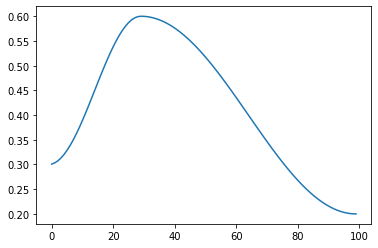

In [141]:
plt.plot(a, [sched(o) for o in p])

You need to train at a high learning rate for a long time, but you also want to train at a very low learning rate for a long time, and you want a gentle learning rate at the beginning when things are fragile.

Therefore, want cosine scheduler to warm up and cool down our learning rates as we train.

In [142]:
class AvgStats():
    def __init__(self, metrics, in_train): self.metrics,self.in_train = listify(metrics),in_train
    
    def reset(self):
        self.tot_loss,self.count = 0.,0
        self.tot_mets = [0.] * len(self.metrics)
        
    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]
    
    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn

class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

In [143]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [144]:
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [145]:
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

In [146]:
learn = create_learner(get_model, loss_func, data)

In [147]:
class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name): # takes any callback that a user might make
        f = getattr(self, cb_name, None)
        if f and f(): return True # users can replace __call__ itself
        return False # makes this more flexible

class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0
    
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

class CancelTrainException(Exception): pass # let peoples callbacks cancel at any of these levels 
class CancelEpochException(Exception): pass # example, can cancel one epoch but continue to the next one
class CancelBatchException(Exception): pass

In [148]:
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        self.in_train = False
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, yb):
        try:
            self.xb,self.yb = xb,yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')

    def all_batches(self, dl):
        self.iters = len(dl)
        try:
            for xb,yb in dl: self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def fit(self, epochs, learn):
        self.epochs,self.learn,self.loss = epochs,learn,tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self)
            self('begin_fit')
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                self('after_epoch')
            
        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit') 
            self.learn = None

    def __call__(self, cb_name):
        res = False
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) or res
        return res

# Note on use of Exceptions

Exceptions in this usage allow the callback writer to stop any of the main parts from things happening.

In this example, will use it to stop training in order to create a learning rate finder!

In [149]:
class TestCallback(Callback):
    _order=1
    def after_step(self):
        print(self.n_iter)
        if self.n_iter>=10: raise CancelTrainException()

In [150]:
run = Runner(cb_funcs=TestCallback)

In [151]:
run.fit(3, learn)

0
1
2
3
4
5
6
7
8
9
10


# Some other callbacks

In [152]:
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)
        
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.in_train: return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])
        
    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs    = self.lrs[pgid]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs): self.pname,self.sched_funcs = pname,sched_funcs
        
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        for pg,f in zip(self.opt.param_groups,self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

# Making a Learning Rate Finder from Scratch

You may want to also add something that saves the model before running this, and loads it back after running - **otherwise you'll lose your weights!**

In [153]:
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9
    # in begin batch, uses exponential curve to set the learning rate    
    def begin_batch(self): 
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos # curve to set lr
        for pg in self.opt.param_groups: pg['lr'] = lr
    # after each step, checks to see if we've done more than the maximum number of iterations (default is 100)     
    def after_step(self): # or, whether the loss is much worse than the best we've had 
        # if EITHER happens, we raise CancelTrainException, which cancels training
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException() # this cancels training once you've found your learning rate!
        if self.loss < self.best_loss: self.best_loss = self.loss
        # see if the loss is better than our best loss - if so, make this better loss our new loss

In fastai we also use exponential smoothing on the loss. For that reason we check for `best_loss*3` instead of `best_loss*10`.

In [154]:
learn = create_learner(get_model, loss_func, data)

In [155]:
run = Runner(cb_funcs=[LR_Find, Recorder])

In [156]:
run.fit(2, learn)

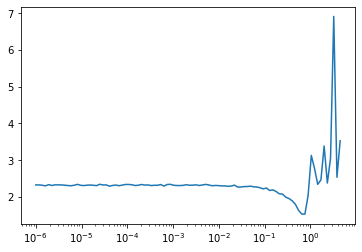

In [157]:
run.recorder.plot(skip_last=5)

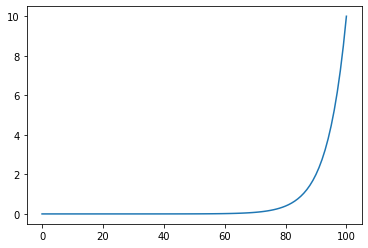

In [158]:
run.recorder.plot_lr()

In [159]:
# only does less than 100 epochs, knnow around where we want to stop

# Let's make it Convolutional!

In [160]:
def normalize_to(train, valid):
    m,s = train.mean(), train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [161]:
x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [162]:
x_train.mean(), x_train.std()

(tensor(0.0001), tensor(1.))

In [163]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

When refactoring, use ```Lambda``` layer that takes a basic function input and converts this to a layer that you can add to ```nn.Sequential```.

Best to give a name to the function you're using inside of your Lambda (like flatten below)

In [164]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x): return self.func(x)
    
def flatten(x): return x.view(x.shape[0], -1)

In [165]:
# takes flat vector of size bs x 784, puts it back as batch of images in 
# 28 by 28 pixel resolution
def mnist_resize(x): return x.view(-1,1,28,28) # .view resizes stuff!

In [166]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d(1, 8, 5, padding=2, stride=2), nn.ReLU(), #14
        nn.Conv2d(8, 16, 3, padding=1, stride=2), nn.ReLU(), #7
        nn.Conv2d(16, 32, 3, padding=1, stride =2), nn.ReLU(), #4
        nn.Conv2d(32, 32, 3, padding=1, stride =2), nn.ReLU(), #2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32, data.c)
    )

# sequential model that contains a bunch of stride 2 convolutions
# remember = input is 28 by 28
# So after the first convolution, input is 14 (dividing 28 in half)
# After the second convolution, input is 7 x 7
# then 4 x 4, 2 x 2
# Do average pooling of all the activations
# flatten the results
# pass it through a linear layer
# Done!

# Use Lambda here to resize our input and flatten our output, all within nn.Sequential itself

In [167]:
model = get_cnn_model(data)

In [168]:
cbfs = [Recorder, partial(AvgStatsCallback, accuracy)]
# partial means I'm treating the AvgStatsCallback class like a function
# Here I'm passing it accuracy, and from this I want it to 
# calculate the average accuracy of my performance per minibatch

In [169]:
opt = optim.SGD(model.parameters(), lr = 0.4) # specifying our optimizer, SGD 
learn = Learner(model, opt, loss_func, data) # Create our learner, ready for training 
run = Runner(cb_funcs = cbfs) # Run our model for training, pass in our callback functions

In [170]:
%timeit run.fit(1, learn)

train: [0.4471877734375, tensor(0.8527)]
valid: [0.577237451171875, tensor(0.8937)]
train: [0.10073755859375, tensor(0.9698)]
valid: [0.13612435302734374, tensor(0.9608)]
train: [0.072993974609375, tensor(0.9770)]
valid: [0.08973518676757812, tensor(0.9712)]
train: [0.057587626953125, tensor(0.9825)]
valid: [0.06235679321289062, tensor(0.9825)]
train: [0.0468539599609375, tensor(0.9853)]
valid: [0.16710936279296876, tensor(0.9542)]
train: [0.04255091796875, tensor(0.9863)]
valid: [0.06998163452148437, tensor(0.9795)]
train: [0.03756271728515625, tensor(0.9878)]
valid: [0.05567471923828125, tensor(0.9848)]
train: [0.0338171533203125, tensor(0.9895)]
valid: [0.05486966552734375, tensor(0.9865)]
5.87 s ± 247 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [171]:
run.fit(1, learn)

train: [0.03292178955078125, tensor(0.9892)]
valid: [0.05591175537109375, tensor(0.9860)]


# That took a long time! Let's use our GPU

### CUDA

A simple Callback can make sure the model, inputs and targets are all on the same device.

Put the model on the GPU - specifically means the model's parameters, because remember a model only contains two types of numbers, **parameters (or weights) and activations (the things that it's calculating)**. 

So the **parameters are what are stored on the GPU (not the activations)**.

And the inputs to the models and the loss function **also go on the GPU**.

Use a CUDA callback:
- pass it a device
- when you begin fitting, you move the model to that device
- when we begin a batch - set the runner's xb and yb and move to the device, which is going to run everything on CUDA

In [172]:
device = torch.device('cuda', 0) # most flexible way
# allows you to work with multiple GPUS

In [173]:
class CudaCallback(Callback):
    def __init__(self, device): self.device=device
    def begin_fit(self): self.model.to(device)
    def begin_batch(self): self.run.xb, self.run.yb = self.xb.to(device), self.yb.to(device)

In [174]:
torch.cuda.set_device(device) # less flexible, but easy
# one GPU as default

In [175]:
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb, self.run.yb = self.xb.cuda(), self.yb.cuda()

In [176]:
cbfs.append(CudaCallback)

In [177]:
model = get_cnn_model(data)

In [178]:
opt = optim.SGD(model.parameters(), lr = 0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs = cbfs)

In [179]:
%timeit run.fit(3, learn)

train: [0.4795509375, tensor(0.8381, device='cuda:0')]
valid: [0.10234592895507813, tensor(0.9686, device='cuda:0')]
train: [0.09267720703125, tensor(0.9717, device='cuda:0')]
valid: [0.07000151977539062, tensor(0.9805, device='cuda:0')]
train: [0.06968955078125, tensor(0.9784, device='cuda:0')]
valid: [0.06732953491210937, tensor(0.9816, device='cuda:0')]
train: [0.0556686376953125, tensor(0.9825, device='cuda:0')]
valid: [0.08169276123046874, tensor(0.9784, device='cuda:0')]
train: [0.0482647265625, tensor(0.9852, device='cuda:0')]
valid: [0.06671342163085937, tensor(0.9832, device='cuda:0')]
train: [0.041343720703125, tensor(0.9869, device='cuda:0')]
valid: [0.0775447021484375, tensor(0.9813, device='cuda:0')]
train: [0.036207958984375, tensor(0.9888, device='cuda:0')]
valid: [0.0727143798828125, tensor(0.9800, device='cuda:0')]
train: [0.033651142578125, tensor(0.9886, device='cuda:0')]
valid: [0.06400704345703125, tensor(0.9840, device='cuda:0')]
train: [0.02669377685546875, tenso

In [180]:
# 7.02 seconds for 3 epochs compared to 5.87 seconds for 1 epoch
# 2.5 times faster!

# Refactor Model

#### Regroup all the conv and relu functions into a single group

In [182]:
def conv2d(ni, nf, ks=3, stride=2): # using kernel size 3, stride size 2
    return nn.Sequential(
    nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU()) # adding a ReLU step here

In [183]:
# callback transforms the independent variable, x, for a batch
# let's you do something like resize images to a specific 
# tensor size on the fly
class BatchTransformXCallback(Callback):
    _order = 2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

        
def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [184]:
mnist_view = view_tfm(1, 28, 28) 

In [192]:
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [193]:
# With AdaptiveAvgPool - model can now work with any size input

nfs = [8,16,32,32] 
# number of filters I have per layer

In [194]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [ # first few layers are for each one of the filters
        # conv2d from one filter to the next one
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3) # kernel size - it's a five for the first layer and 3 for the next layers
        for i in range(len(nfs)-1)
        
# why does the kernel size change?
# see markdown below
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]
# last layers - average pooling, flattening, and linear layer
def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

Number of filters in the first layer - 8.

Image has a single channel, and imagine we were using 3 x 3 filters.
At each point in time, looking at 3x3 window with one channel - in total there's 9 input activations it's looking at. And then, spits those into 8 by 9 matrix multiply and then finally into a vector of length 8. Started with 9 numbers, then end up with 8 numbers, so all we're really doing is reordering the numbers, and not doing any useful computation. **So, there's no point in having your first layer just shuffle numbers into a different order. That's why we use a different kernel size for first layer.**


ImageNet models - have 27 numbers - 3x3x3 for all three channels. Usually start with a 7 by 7 kernel, not 3x3. For the same reason, **we're making the first layer here have a 5x5 kernel size**. 27 to 32, we're wasting information, if you start with 27 numbers and do matrix multiplication to get 32 numbers, taking up more space for the same information you started with - the whole point of the neurla network layer is to pull out interesting fdeatures, so you want less activations (smaller dot product) 

In [196]:
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [197]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [198]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [199]:
run.fit(3, learn)

train: [0.5143558984375, tensor(0.8247, device='cuda:0')]
valid: [0.09866397094726563, tensor(0.9695, device='cuda:0')]
train: [0.097219296875, tensor(0.9694, device='cuda:0')]
valid: [0.3335225341796875, tensor(0.9157, device='cuda:0')]
train: [0.069650908203125, tensor(0.9781, device='cuda:0')]
valid: [0.27952236328125, tensor(0.9297, device='cuda:0')]


# How do we make this more accurate, train more stabley, train more quickly?

### Hooks

Let's replace PyTorch's ```nn.Sequential``` with our own sequential class

In [209]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
        
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds[i].append(x.data.std())
        return x
    # same as before, except has an act means and act standard deviations compontent in __call__
    def __iter__(self): return iter(self.layers)

In [210]:
model = SequentialModel(*get_cnn_layers(data, nfs)) # nfs = number of filters

In [211]:
learn, run = get_runner(model, data, lr = 0.9, cbs = cbfs)

In [212]:
run.fit(2, learn)

train: [2.271030625, tensor(0.1402, device='cuda:0')]
valid: [2.1997154296875, tensor(0.1415, device='cuda:0')]
train: [1.3700453125, tensor(0.5407, device='cuda:0')]
valid: [1.543443359375, tensor(0.7139, device='cuda:0')]


### Let's now look at the means and standard deviations of the activations at the beginning of training. 

In [213]:
print(model.act_means)

[[tensor(0.1671, device='cuda:0'), tensor(0.1697, device='cuda:0'), tensor(0.1720, device='cuda:0'), tensor(0.1717, device='cuda:0'), tensor(0.1643, device='cuda:0'), tensor(0.1662, device='cuda:0'), tensor(0.1721, device='cuda:0'), tensor(0.1772, device='cuda:0'), tensor(0.1783, device='cuda:0'), tensor(0.1841, device='cuda:0'), tensor(0.1778, device='cuda:0'), tensor(0.1854, device='cuda:0'), tensor(0.1934, device='cuda:0'), tensor(0.2014, device='cuda:0'), tensor(0.2041, device='cuda:0'), tensor(0.2165, device='cuda:0'), tensor(0.2129, device='cuda:0'), tensor(0.2337, device='cuda:0'), tensor(0.2649, device='cuda:0'), tensor(0.2971, device='cuda:0'), tensor(0.2060, device='cuda:0'), tensor(0.2128, device='cuda:0'), tensor(0.1956, device='cuda:0'), tensor(0.2084, device='cuda:0'), tensor(0.2403, device='cuda:0'), tensor(0.2690, device='cuda:0'), tensor(0.1589, device='cuda:0'), tensor(0.1561, device='cuda:0'), tensor(0.1579, device='cuda:0'), tensor(0.1578, device='cuda:0'), tensor(0

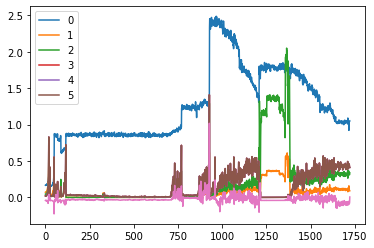

In [214]:
for l in model.act_means: plt.plot(l)
plt.legend(range(6));

# Looks really bad
### During every session of training, the means get exponentially bigger, until they suddenly collapses. That's what these sharp peaks represent.

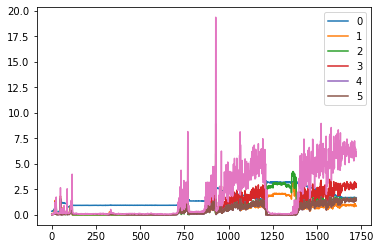

In [215]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6));

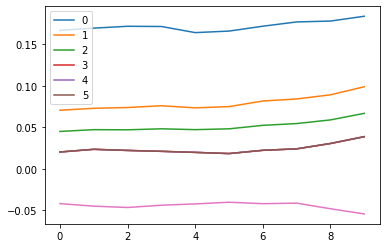

In [216]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(6));

#### The first 10 means look okay, close to zero which is what we want

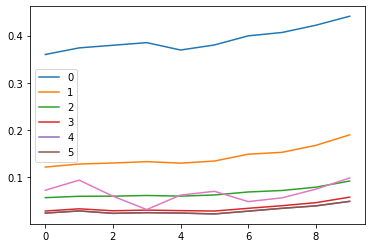

In [217]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6));

#### The first standard deviation is close ish to one, but then the next standard deviations just keep getting lower

What's happening - our final layers are **getting no gradients!** 